# Solution using a DenseNet
Solution by Luca Lanzo

### Problem description
The classification of the Fashion-MNIST dataset is also a good opportunity to test out a DenseNet architecture.

### Proposed solution
Use the standard Fashion-MNIST dataset from the torchvision library to train a model able to classify the images by their type.

## Coded Solution

### Step 1: Importing all necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Step 2: Setup CUDA for parallel computation

While the sequential computations run on the CPU, Pytorch can offload the heavy duty parallel computations onto the GPU.
Not every user running this notebook has CUDA enabled so I have coded a short device check which creates the data and the model either on CUDA or CPU.

In [2]:
print(f'Cuda available: {torch.cuda.is_available()}')

device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda available: True


### Step 3: Get the Fashion-MNIST train and test dataset

In [3]:
mnist_train = datasets.FashionMNIST(root='datasets', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST(root='datasets', train=False, download=True, transform=transforms.ToTensor())

### Step 4: Instantiate the DataLoaders

In [4]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### Step 5: Defining the CNN model

#### Step 5.1: Defining the DenseLayer
It is important to add zero-padding to the convolutional layer in order to preserve the spatial dimension of the tensor.

In [5]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        # Kernel size fixed to 3x3
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same')
        
    def forward(self, x):
        x = self.bn(x)
        x = F.relu(x)
        x = self.conv(x)
        return x

#### Step 5.2: Defining the DenseBlock
I thought out the following loop to program the DenseBlock architecture. On init the code will create a variable amount of DenseLayers each with increasing channel sizes. On forward, it iterates through the DenseLayers and runs the Layer. After it the result gets concatenated to the previous DenseLayer-results. It follows this model:  
$$\mathcal{x_l = H_l ([x_0, x_1,  ... , x_{l-1}])}$$


In [6]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels):
        super().__init__()
        self.layers = []
        
        for _ in range(num_layers):
            self.layers.append(DenseLayer(in_channels, out_channels).to(device))
            
            # The channel size will double with each concat
            in_channels *= 2
            out_channels *= 2
    
    def forward(self, x):
        concat = x
        out = None
        
        for dense_layer in self.layers:
            
            out = dense_layer(concat)
            concat = torch.cat((concat, out), 1)
        
        return concat

#### Step 5.3: Defining the DenseNet

In [7]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)
        self.ap1 = nn.AvgPool2d(kernel_size=1, stride=2)
        
        self.db1 = DenseBlock(num_layers=3, in_channels=4, out_channels=4).to(device)
        
        # Transition layer
        # The channel dimension gets blown up from 4 to 16 because it doubles after every concatenation (4 to 8 to 16)
        self.bn = nn.BatchNorm2d(num_features=16)    
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=4, kernel_size=1)
        self.ap2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.db2 = DenseBlock(num_layers=3, in_channels=4, out_channels=4).to(device)
        
        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/4?page=2
        # "To do this you can apply ... nn.AvgPool2d ... with kernel_size equal to the dimensions of the feature maps."
        # Dimension of the feature maps is at this point 6x6
        # self.ap3 = nn.AvgPool2d((6,6))
        
        self.f = nn.Flatten()

        self.fc = nn.Linear(576, 10)      
        
    def forward(self, x):
        # pre
        x = self.ap1(self.conv1(x))
        
        # first DenseBlock
        x = self.db1(x)
        
        # transition layer
        x = self.ap2(self.conv2(self.bn(x)))
        
        # second Denseblock
        x = self.db2(x)
        
        # global average pooling
        # I couldn't get my model to work with this. I am not sure what i did wrong, or maybe I misunderstood Global
        # Average Pooling...
        # x = self.ap3(x)
        
        # fully connected layer
        x = self.f(x)
        x = self.fc(x)
        
        return x

#### Step 5.4: Initialise the model and transfer to GPU if possible

In [8]:
model = DenseNet()

# send the model to CUDA
model.to(device)
# print(f'Model has been transferred to CUDA: {next(model.parameters()).is_cuda}')

DenseNet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (ap1): AvgPool2d(kernel_size=1, stride=2, padding=0)
  (db1): DenseBlock()
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
  (ap2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (db2): DenseBlock()
  (f): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)

#### Step 5.5: Some questions

**What is the spatial dimension of the first DenseBlock and how many input channels and output channels does it have?**  
The spatial dimensions are 13 x 13.
The channels are 4 before and 64 after the block.

**What is the spatial dimension of the second DenseBlock?**  
The spatial dimensions are 16 x 16.


**What dimension is the input into the final FC layer?**  
The dimension is 6 x 6 before flattening and after the FC layer gets a 576 long vector.

### Step 6: Define the loss function
The loss function is defined as the cross-entropy loss.

In [9]:
loss_func = nn.CrossEntropyLoss()

### Step 7: Define the optimisation algorithm
The optimisation algorithm is defined as the SGD algorithm.

In [10]:
optimiser = optim.SGD(model.parameters(), lr=0.01)

### Step 8: Model training procedure

In [11]:
def model_training(trainloader, model, loss_func, optimiser):
    num_epochs = 100 # tweak for optimisation
    
    losses = []
    
    # Set the model to training mode
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            # transfer data to GPU
            images, labels = images.to(device), labels.to(device)
            
            # training pass
            optimiser.zero_grad()
            
            # get predictions
            output = model(images)
            
            # get loss value
            loss = loss_func(output, labels)
            
            # go in the direction opposite of the gradient
            loss.backward()
            
            # update parameter values
            optimiser.step()
            
            running_loss += loss.item()
            
        losses.append(running_loss/i)
        print(f'Epoch {epoch+1}/{num_epochs} --- Loss {running_loss/i}')
        
    return losses

In [12]:
losses = model_training(trainloader, model, loss_func, optimiser)

Epoch 1/100 --- Loss 1.3477188667171023
Epoch 2/100 --- Loss 0.8243412766446415
Epoch 3/100 --- Loss 0.7272820726164386
Epoch 4/100 --- Loss 0.6815428147331263
Epoch 5/100 --- Loss 0.6524777266586947
Epoch 6/100 --- Loss 0.6302472242178061
Epoch 7/100 --- Loss 0.6132664836497388
Epoch 8/100 --- Loss 0.5981381617040715
Epoch 9/100 --- Loss 0.5866408160226977
Epoch 10/100 --- Loss 0.5755980991654925
Epoch 11/100 --- Loss 0.5662113261910585
Epoch 12/100 --- Loss 0.5572526456835942
Epoch 13/100 --- Loss 0.549684611395893
Epoch 14/100 --- Loss 0.5431421681219696
Epoch 15/100 --- Loss 0.5369734949408433
Epoch 16/100 --- Loss 0.5312277175422407
Epoch 17/100 --- Loss 0.526281042995616
Epoch 18/100 --- Loss 0.5211050123867825
Epoch 19/100 --- Loss 0.5175753500726488
Epoch 20/100 --- Loss 0.5129472721590955
Epoch 21/100 --- Loss 0.5097024098802836
Epoch 22/100 --- Loss 0.5059092652976004
Epoch 23/100 --- Loss 0.5021208451471777
Epoch 24/100 --- Loss 0.4997178917893997
Epoch 25/100 --- Loss 0.496

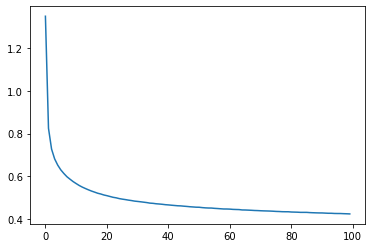

In [13]:
# plot the losses after finishing the training
plt.plot(losses)

### Step 10: Check the overall performance on all test images
Important: The model has to be set to evaluation mode in order to turn off Dropout and BatchNorm (and other layers/parts of the model). Just to try it out I left the model on CUDA and tested it like this.

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'The accuracy of the model on all test images is {100 * correct / total} %')

if ((100 * correct / total) > 85):
    plt.imshow(plt.imread('important_reaction_picture.jpg'))

The accuracy of the model on all test images is 83.6 %


### Step 11: Evaluating the model and the performance¶

Here are my results using the DenseNet:   


_lr=0.1, epochs=30, batch_size=128_  
I got a 85.01 % accuracy. This is quite good but I am going to let it run for some more epochs and decrease the learning rate

_**lr=0.01**, **epochs=100**, batch_size=128_   
83,6 %. This actually got a worse accuracy, so I will stick with a 0.1 learning rate.


---
I will stop this a bit sooner than on the other solution (with ResBlocks), as I don't think I can get any better results if I let it run any longer :) 
I choose the following hyper parameters for my model:  
**lr=0.1, epochs=100, batch_size=128**: This will yield a good result with which I am content.